In [ ]:
!python -m spacy download en_core_web_sm

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from pathlib import Path
import pandas as pd
import spacy
# Add project root to Python path (go up one level from notebooks/)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from main import load_config
import numpy as np
from collections import Counter
import re

In [19]:
config = load_config("configs/config.yaml")
model_name_destileldBert = 'distilbert-base-uncased'
model_name_bert = 'bert-base-uncased'


Loaded config from c:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\configs\config.yaml


In [20]:
# ...existing code...
from pathlib import Path
import os

def find_project_root(start: Path = None, markers=(".git", "pyproject.toml", "setup.py")) -> Path:
    start = Path(start or Path.cwd()).resolve()
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return Path.cwd()

# Prefer explicit env var for cloud runs; otherwise try __file__ then cwd then repo-root
project_root = None
if "PROJECT_ROOT" in os.environ:
    project_root = Path(os.environ["PROJECT_ROOT"]).resolve()
else:
    try:
        # works in scripts, not in notebooks
        project_root = Path(__file__).parent.resolve()
    except NameError:
        # notebook / interactive fallback: try repo root then cwd
        project_root = find_project_root()

# build paths relative to project_root
notebooks_dir = project_root / "notebooks"
mis_dir = notebooks_dir / "misclassifications"

bert_path = mis_dir / "top_misclassifications_Stanford_bert_partial_finetune.csv"
bert_lora_path = mis_dir / "top_misclassifications_Stanford_bert_lora_r8.csv"
distilled_bert_path = mis_dir / "top_misclassifications_Stanford_distilbert_lora_r8.csv"
distilled_bert_lora_path = mis_dir / "top_misclassifications_Stanford_distilbert_partial_finetune.csv"

print("Using project_root:", mis_dir)

Using project_root: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\notebooks\misclassifications


In [21]:
# ...existing code...
from pathlib import Path

def find_file(name, start=project_root):
    start = Path(start or Path.cwd()).resolve()
    return list(start.rglob(name))

print("project_root:", project_root)
print("mis_dir:", mis_dir)
print("expected bert_path:", bert_path)
print("bert_path.exists():", bert_path.exists())

if not bert_path.exists():
    print("Searching repo for top_misclassifications_Stanford_bert_partial_finetune.csv ...")
    found = find_file("top_misclassifications_Stanford_bert_partial_finetune.csv", project_root)
    if not found:
        raise FileNotFoundError(f"Could not locate top_misclassifications_Stanford_bert_partial_finetune.csv under {project_root}")
    bert_path = found[0]
    print("Found bert_path at:", bert_path)

# helper to load or search
def load_or_search(p: Path):
    if isinstance(p, str):
        p = Path(p)
    if p.exists():
        return pd.read_csv(p)
    found = find_file(p.name, project_root)
    if not found:
        raise FileNotFoundError(f"Could not locate {p.name} under {project_root}")
    print(f"Loading {p.name} from {found[0]}")
    return pd.read_csv(found[0])

df_bert = load_or_search(bert_path)
df_bert_lora = load_or_search(bert_lora_path)
df_distilled_bert = load_or_search(distilled_bert_path)
df_distilled_bert_lora = load_or_search(distilled_bert_lora_path)

print("Loaded dataframes:", { 'bert': len(df_bert), 'bert_lora': len(df_bert_lora),
                             'distilled': len(df_distilled_bert), 'distilled_lora': len(df_distilled_bert_lora) })
# ...existing code...

project_root: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project
mis_dir: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\notebooks\misclassifications
expected bert_path: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\notebooks\misclassifications\top_misclassifications_Stanford_bert_partial_finetune.csv
bert_path.exists(): False
Searching repo for top_misclassifications_Stanford_bert_partial_finetune.csv ...
Found bert_path at: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvNLP\Final Exam\AVDNLP_final_project\AVDNLP_final_project\misclassifications\top_misclassifications_Stanford_bert_partial_finetune.csv
Loading top_misclassifications_Stanford_bert_lora_r8.csv from C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS

In [22]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

models = {
    "bert_lora": df_bert_lora,
    "bert_partial": df_bert,
    "distil_lora": df_distilled_bert_lora,
    "distil_partial": df_distilled_bert
}

# Standardize text column name
for name, df in models.items():
    if "text" not in df.columns:
        df.rename(columns={df.columns[0]: "text"}, inplace=True)


# -------------------------------------------------------------------
# HELPERS
# -------------------------------------------------------------------

def extract_keywords(texts, top_k=20):
    words = []
    for t in texts:
        tokens = re.findall(r"[A-Za-z]+", str(t).lower())
        words.extend([w for w in tokens if w not in stopwords and len(w) > 2])
    
    counts = Counter(words)
    return counts.most_common(top_k)


def compute_label_distribution(df):
    return df["true_label"].value_counts(normalize=True)


def overlap_rate(a, b):
    """Measure textual overlap between two sets of edge cases."""
    s1 = set(a["text"].tolist())
    s2 = set(b["text"].tolist())
    return len(s1 & s2) / len(s1 | s2)

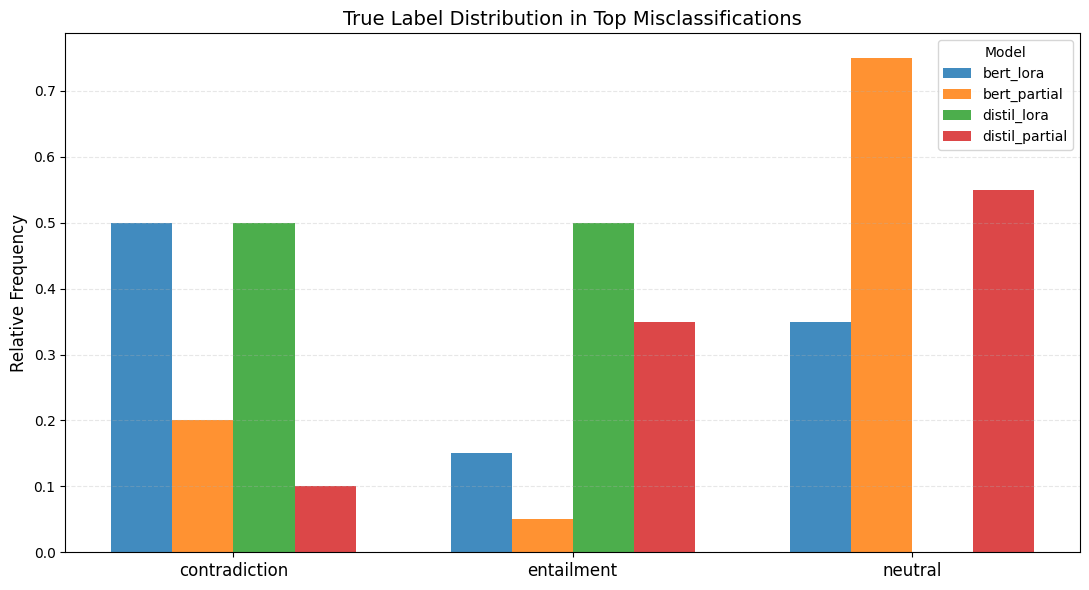

In [38]:
# Collect all label names
label_set = sorted(set().union(*[df["true_label"].unique() for df in models.values()]))

# Build matrix: rows = labels, columns = models
dist_matrix = pd.DataFrame(
    {
        name: df["true_label"].value_counts(normalize=True)
                           .reindex(label_set, fill_value=0)
        for name, df in models.items()
    }
)

labels = label_set
model_names = list(models.keys())

n_labels = len(labels)
n_models = len(model_names)

x = np.arange(n_labels)
width = 0.18  # bar width

plt.figure(figsize=(11, 6))

for i, name in enumerate(model_names):
    plt.bar(
        x + (i - n_models/2) * width + width/2,
        dist_matrix[name],
        width,
        label=name,
        alpha=0.85
    )

plt.xticks(x, labels, fontsize=12)
plt.ylabel("Relative Frequency", fontsize=12)
plt.title("True Label Distribution in Top Misclassifications", fontsize=14)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

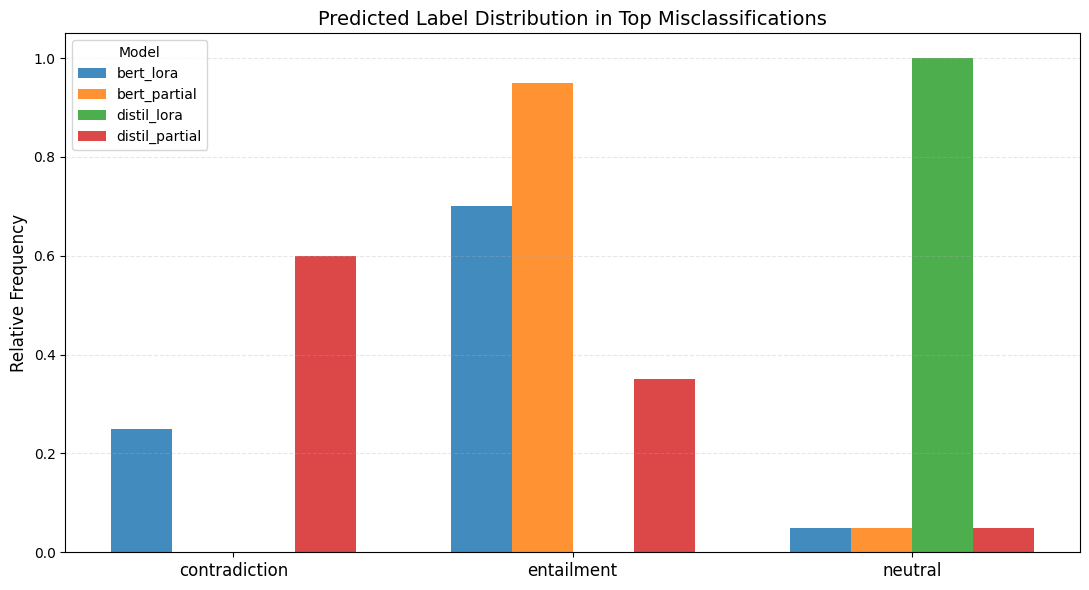

In [37]:
# Collect all predicted label names
pred_label_set = sorted(set().union(*[df["predicted_label"].unique() for df in models.values()]))

# Build matrix: rows = labels, columns = models
pred_dist_matrix = pd.DataFrame(
    {
        name: df["predicted_label"].value_counts(normalize=True)
                              .reindex(pred_label_set, fill_value=0)
        for name, df in models.items()
    }
)

pred_labels = pred_label_set
model_names = list(models.keys())

n_labels = len(pred_labels)
n_models = len(model_names)

x = np.arange(n_labels)
width = 0.18

plt.figure(figsize=(11, 6))

for i, name in enumerate(model_names):
    plt.bar(
        x + (i - n_models/2) * width + width/2,
        pred_dist_matrix[name],
        width,
        label=name,
        alpha=0.85
    )

plt.xticks(x, pred_labels, fontsize=12)
plt.ylabel("Relative Frequency", fontsize=12)
plt.title("Predicted Label Distribution in Top Misclassifications", fontsize=14)
plt.legend(title="Model")
plt.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# -------------------------------------------------------------------
# 3) KEYWORD ANALYSIS FOR EACH MODEL
# -------------------------------------------------------------------
keyword_summary = {}

for name, df in models.items():
    top_keywords = extract_keywords(df["text"])
    keyword_summary[name] = top_keywords
    print(f"\n===== Top Keywords for {name} =====")
    for w, c in top_keywords[:20]:
        print(f"{w}: {c}")


===== Top Keywords for bert_lora =====
blue: 20
man: 17
wearing: 11
white: 9
woman: 9
shirt: 8
player: 6
jersey: 5
sitting: 5
women: 4
green: 4
building: 4
black: 4
people: 4
bench: 4
little: 4
young: 3
football: 3
red: 3
walking: 3

===== Top Keywords for bert_partial =====
man: 18
people: 10
wearing: 8
black: 7
person: 5
shirt: 5
blue: 5
holding: 5
outside: 4
white: 4
sitting: 4
guitar: 4
playing: 4
young: 3
wall: 3
girl: 3
jacket: 3
long: 3
cutting: 3
looking: 3

===== Top Keywords for distil_lora =====
man: 13
blue: 9
shirt: 8
woman: 7
people: 6
white: 5
crowd: 5
horse: 5
beach: 5
face: 4
boy: 4
person: 4
asian: 4
lady: 4
striped: 3
holding: 3
red: 3
looking: 3
men: 3
race: 3

===== Top Keywords for distil_partial =====
man: 20
black: 13
woman: 10
walking: 5
standing: 5
bowling: 5
people: 5
holding: 4
games: 4
wearing: 4
shirt: 4
jumping: 3
shoes: 3
face: 3
looking: 3
jacket: 3
uniform: 3
basketball: 2
players: 2
little: 2


In [26]:
# -------------------------------------------------------------------
# 4) CREATE KEYWORD VENN-LIKE STATS
# -------------------------------------------------------------------
def keyword_set(topk):
    return set([w for w, _ in topk[:30]])

kw_sets = {name: keyword_set(top) for name, top in keyword_summary.items()}

print("\n===== KEYWORD OVERLAP BETWEEN MODELS =====")
names = list(models.keys())

for i in range(len(names)):
    for j in range(i+1, len(names)):
        a, b = names[i], names[j]
        overlap = len(kw_sets[a] & kw_sets[b])
        print(f"{a} ↔ {b}: {overlap} overlapping keywords")


===== KEYWORD OVERLAP BETWEEN MODELS =====
bert_lora ↔ bert_partial: 9 overlapping keywords
bert_lora ↔ distil_lora: 7 overlapping keywords
bert_lora ↔ distil_partial: 8 overlapping keywords
bert_partial ↔ distil_lora: 8 overlapping keywords
bert_partial ↔ distil_partial: 8 overlapping keywords
distil_lora ↔ distil_partial: 7 overlapping keywords


In [27]:
# -------------------------------------------------------------------
# 5) TEXTUAL OVERLAP (how many identical edge cases each model shares?)
# -------------------------------------------------------------------
print("\n===== TEXTUAL OVERLAP (Jaccard-like) =====")
for i in range(len(names)):
    for j in range(i+1, len(names)):
        a, b = names[i], names[j]
        ov = overlap_rate(models[a], models[b])
        print(f"{a} ↔ {b}: {ov:.3f}")


===== TEXTUAL OVERLAP (Jaccard-like) =====
bert_lora ↔ bert_partial: 0.000
bert_lora ↔ distil_lora: 0.000
bert_lora ↔ distil_partial: 0.000
bert_partial ↔ distil_lora: 0.000
bert_partial ↔ distil_partial: 0.111
distil_lora ↔ distil_partial: 0.000


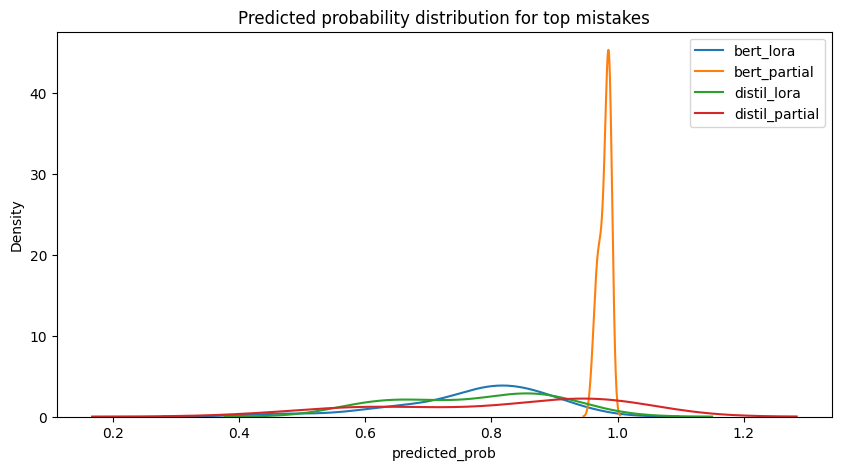

In [28]:
# -------------------------------------------------------------------
# 6) CONFIDENCE DISTRIBUTIONS
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for name, df in models.items():
    sns.kdeplot(df["predicted_prob"], label=name, ax=ax)

ax.set_title("Predicted probability distribution for top mistakes")
ax.legend()
plt.show()

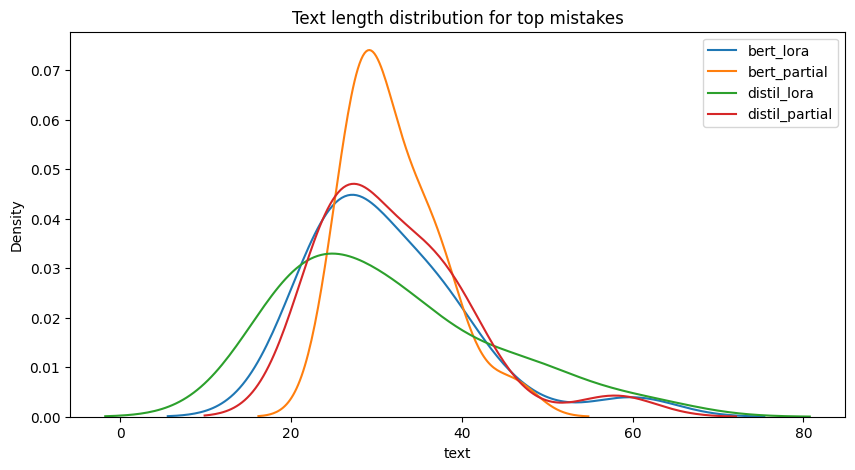

In [29]:
# -------------------------------------------------------------------
# 7) LENGTH ANALYSIS
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for name, df in models.items():
    sns.kdeplot(df["text"].str.split().str.len(), label=name, ax=ax)

ax.set_title("Text length distribution for top mistakes")
ax.legend()
plt.show()

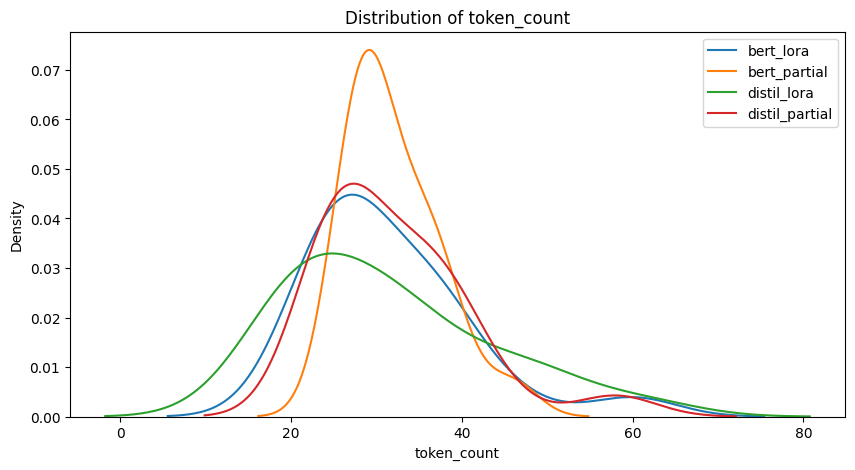

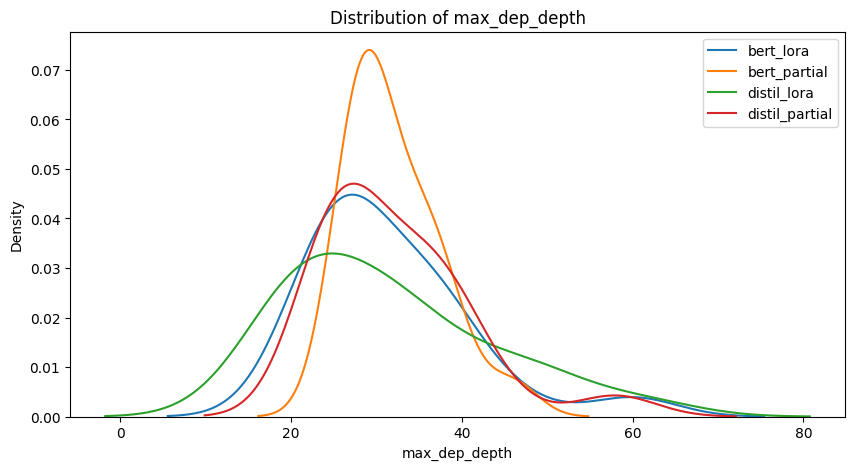

C:\Users\Besitzer\AppData\Local\Temp\ipykernel_18040\363680852.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], label=name)
C:\Users\Besitzer\AppData\Local\Temp\ipykernel_18040\363680852.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], label=name)
C:\Users\Besitzer\AppData\Local\Temp\ipykernel_18040\363680852.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], label=name)
C:\Users\Besitzer\AppData\Local\Temp\ipykernel_18040\363680852.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[col], label=name)
C:\Users\Besitzer\AppData\Local\Temp\ipykernel_18040\363680852.py:11: UserWarning: No artists with labels found to put i

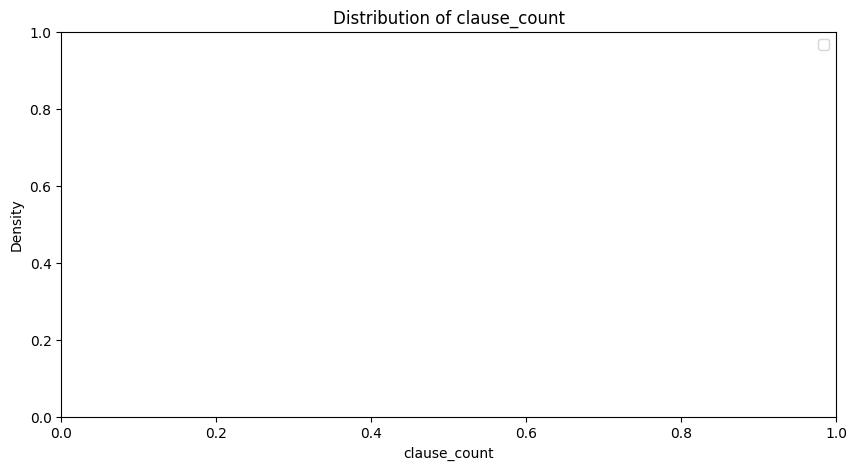

In [30]:
# -------------------------------------------------------------------
# 8) STRUCTURAL FEATURES COMPARISON
# -------------------------------------------------------------------
struct_cols = ["token_count", "max_dep_depth", "clause_count"]
for col in struct_cols:
    plt.figure(figsize=(10, 5))
    for name, df in models.items():
        if col in df.columns:
            sns.kdeplot(df[col], label=name)
    plt.title(f"Distribution of {col}")
    plt.legend()
    plt.show()

In [31]:
def analyze_probabilities(df, model_name="Model"):
    print(f"=== Probability Analysis for {model_name} ===")

    df["diff_prob"] = df["predicted_prob"] - df["true_prob"]

    fig, axes = plt.subplots(1, 3, figsize=(22, 6))

    # 1: Scatter
    sns.scatterplot(
        data=df,
        x="true_prob",
        y="predicted_prob",
        hue="predicted_label",
        alpha=0.6,
        ax=axes[0]
    )
    axes[0].set_title("True vs Predicted Prob")
    axes[0].grid(alpha=0.3)

    # 2: Predicted KDE
    for label in df['predicted_label'].unique():
        sns.kdeplot(
            df[df['predicted_label'] == label]['predicted_prob'],
            label=label,
            ax=axes[1]
        )
    axes[1].set_title("Predicted Prob Distribution")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # 3: Difference boxplot
    sns.boxplot(
        data=df,
        x="predicted_label",
        y="diff_prob",
        ax=axes[2]
    )
    axes[2].set_title("Predicted − True Probability")
    axes[2].grid(alpha=0.3)

    plt.suptitle(f"{model_name} Probability Analysis", fontsize=16)
    plt.tight_layout()
    plt.show()


=== Probability Analysis for BERT LoRA ===


C:\Users\Besitzer\AppData\Local\Temp\ipykernel_18040\1635967192.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


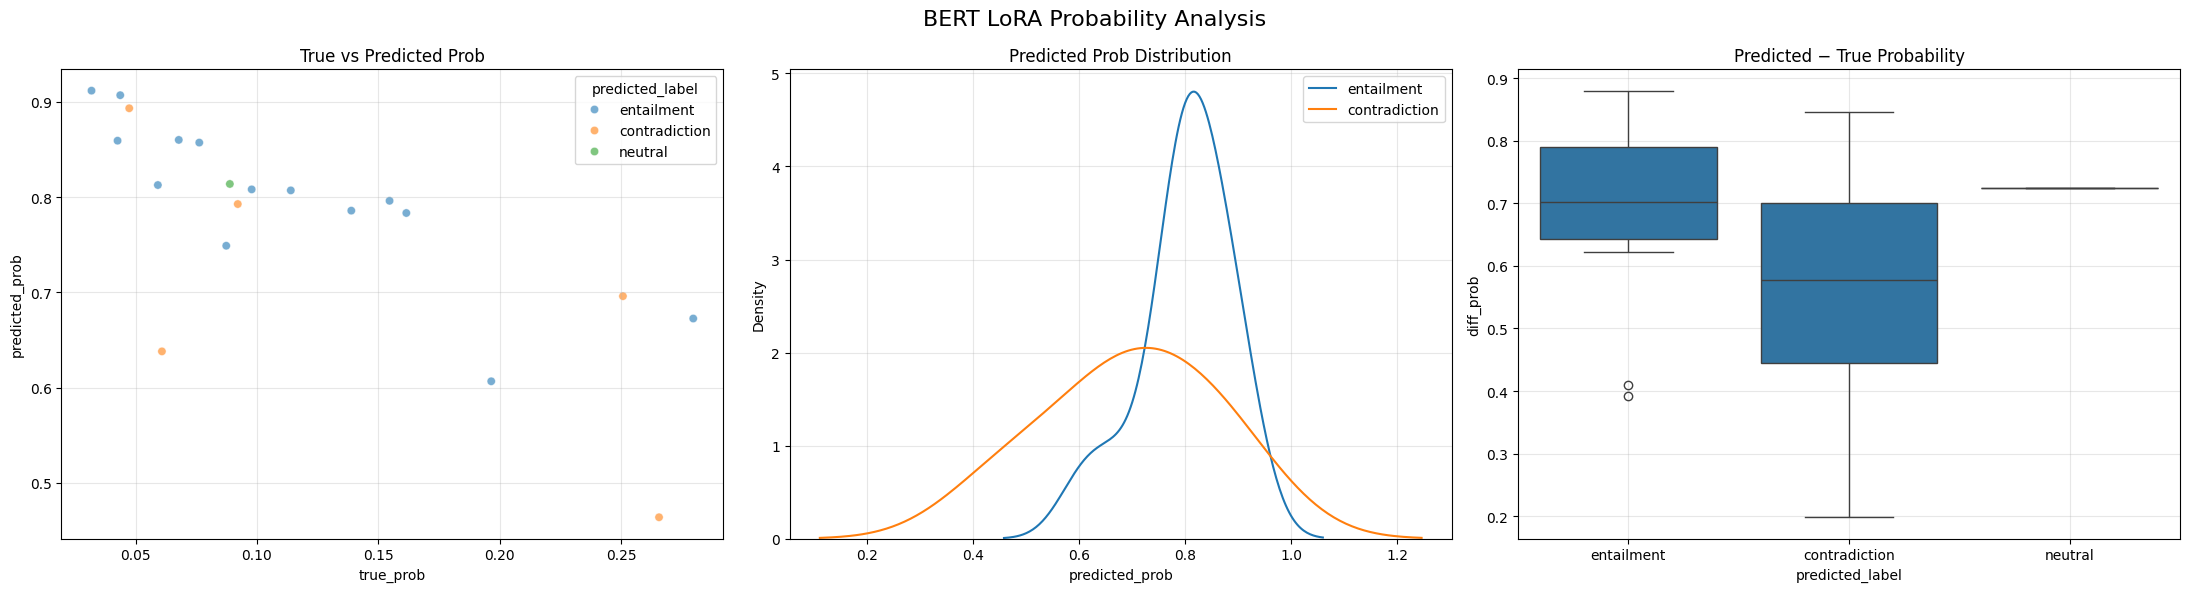

In [32]:
analyze_probabilities(df_bert_lora, "BERT LoRA")

=== Probability Analysis for BERT LoRA Partial Fine-tune ===


C:\Users\Besitzer\AppData\Local\Temp\ipykernel_18040\1635967192.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


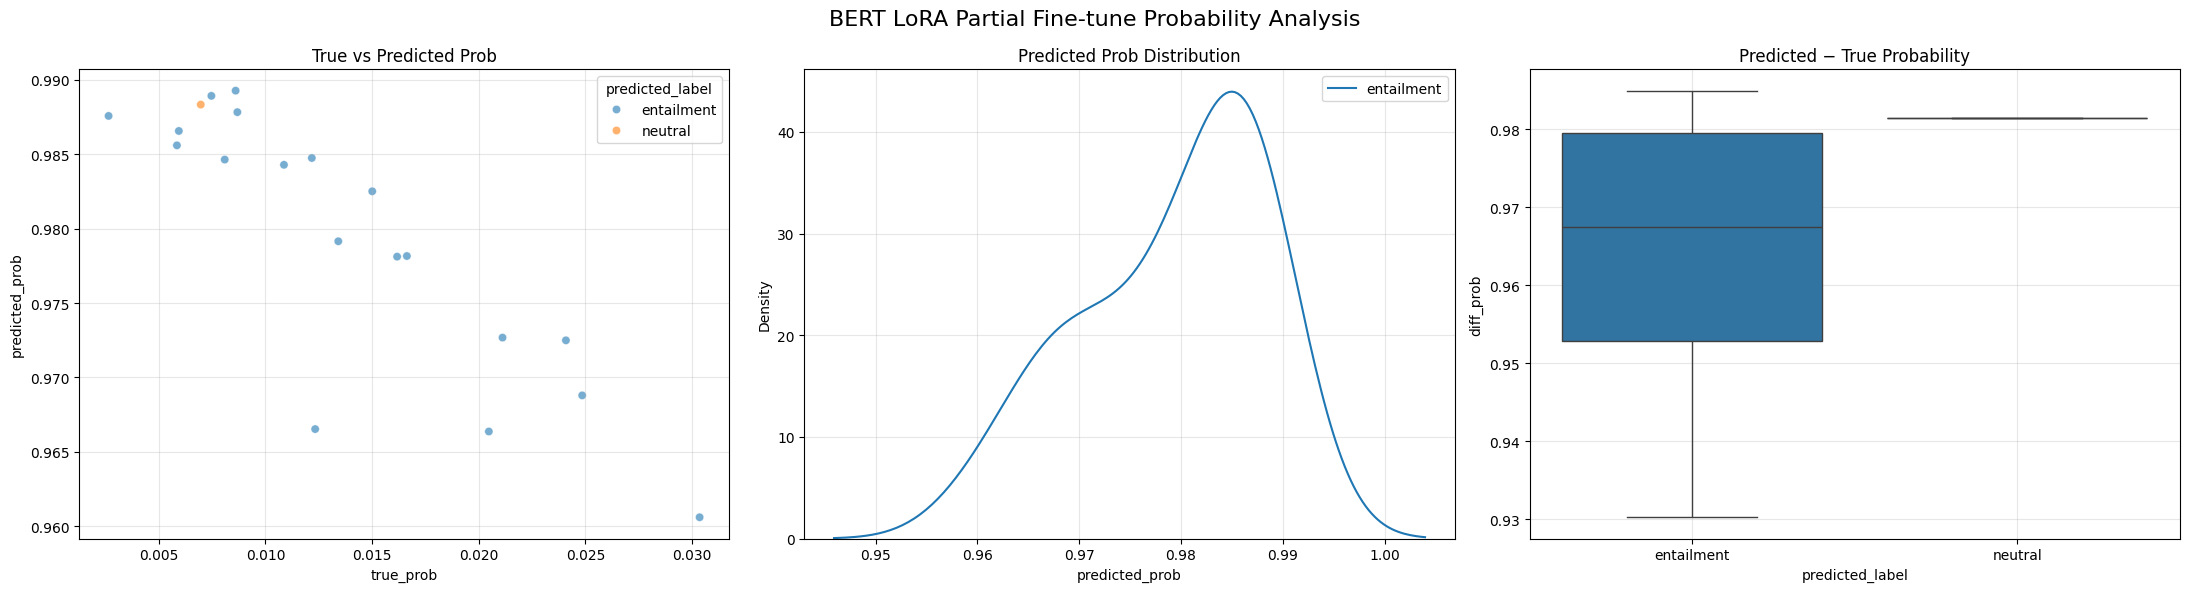

In [33]:
analyze_probabilities(df_bert, "BERT LoRA Partial Fine-tune")

=== Probability Analysis for Destileld BERT LoRA ===


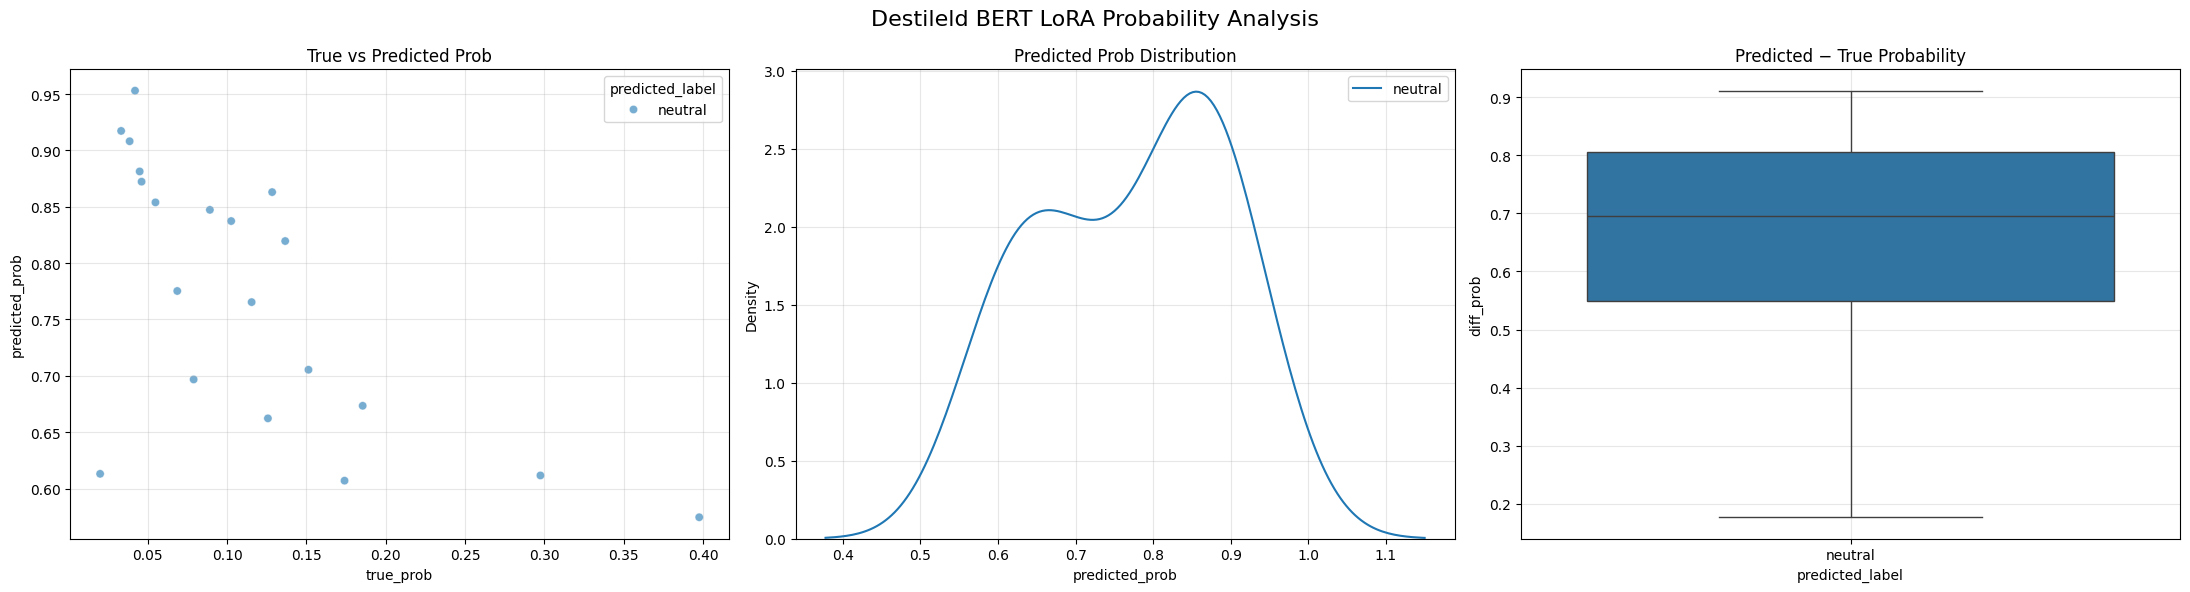

In [34]:
analyze_probabilities(df_distilled_bert_lora, "Destileld BERT LoRA")

=== Probability Analysis for DEstilled BERT Partial ===


C:\Users\Besitzer\AppData\Local\Temp\ipykernel_18040\1635967192.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


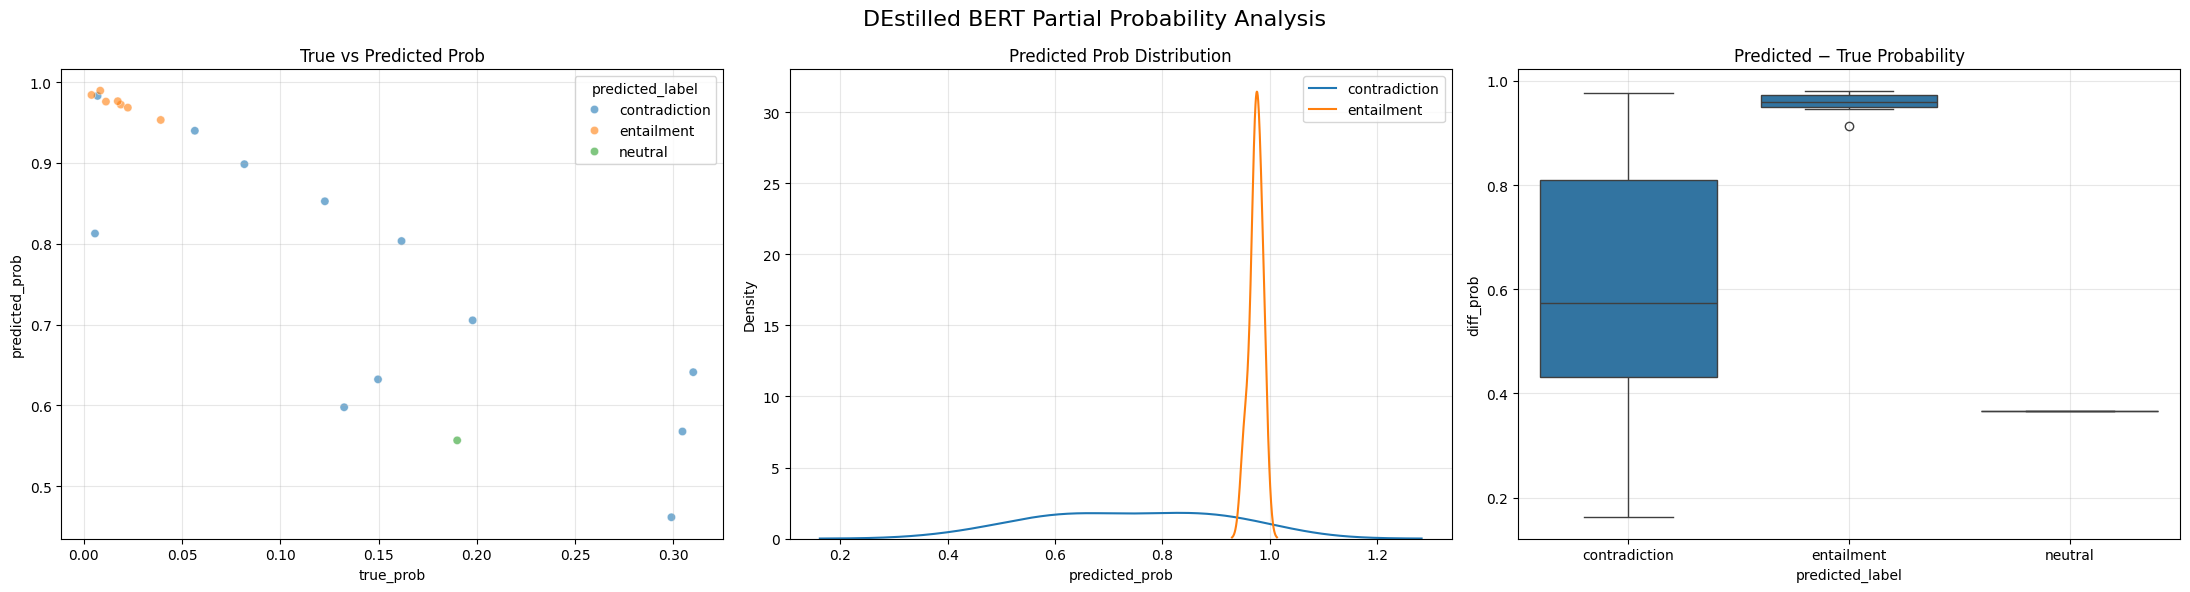

In [35]:
analyze_probabilities(df_distilled_bert, "DEstilled BERT Partial")